In [1]:
import pandas as pd
import numpy as np

from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
expr = pd.read_csv(
    "C:/Users/Aina Rif'ah/Downloads/INTERNSHIP/PROJECT 2/data/processed/GSE112509_log_normalized.csv",
    index_col=0
)

metadata = pd.read_csv(
    "C:/Users/Aina Rif'ah/Downloads/INTERNSHIP/PROJECT 2/data/processed/GSE112509_metadata.csv",
    index_col=0
)

expr.shape, metadata.shape


((29830, 79), (79, 6))

In [3]:
expr = expr[metadata.index]


In [5]:
metadata.columns


Index(['tissue', 'group', 'nevus type', 'braf mutation', 'nras mutation',
       'condition'],
      dtype='object')

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(expr.T)  # samples × genes


In [8]:
kmeans = KMeans(n_clusters=2, random_state=42)
metadata["KMeans_cluster"] = kmeans.fit_predict(X_scaled)

metadata["KMeans_cluster"].value_counts()


C:\BLAST\envs\varpred\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans_cluster
1    42
0    37
Name: count, dtype: int64

In [10]:
metadata.to_csv(
    "C:/Users/Aina Rif'ah/Downloads/INTERNSHIP/PROJECT 2/data/processed/GSE112509_metadata_with_clusters.csv"
)


In [11]:
metadata["Cluster"] = metadata["KMeans_cluster"]
metadata["Cluster"].value_counts()


Cluster
1    42
0    37
Name: count, dtype: int64

In [12]:
gene_variance = expr.var(axis=1)
top_variable_genes = gene_variance.sort_values(ascending=False).head(1000)

top_variable_genes.head()


GeneID
6192      37.343950
8653      31.099706
8284      28.958240
246126    27.860943
7503      27.328485
dtype: float64

In [13]:
expr_var = expr.loc[top_variable_genes.index]


In [14]:
cluster_means = expr_var.groupby(metadata["Cluster"], axis=1).mean()
cluster_means.head()


C:\Users\Aina Rif'ah\AppData\Local\Temp\ipykernel_28560\3899215401.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  cluster_means = expr_var.groupby(metadata["Cluster"], axis=1).mean()


Cluster,0,1
GeneID,,
6192,6.995674,8.278544
8653,6.092520,6.969778
8284,5.855050,6.539811
246126,5.553996,5.927646
7503,11.157475,8.047967


In [15]:
marker_genes = {}

for cluster in cluster_means.columns:
    others = cluster_means.drop(columns=cluster)
    diff = cluster_means[cluster] - others.mean(axis=1)
    marker_genes[cluster] = diff.sort_values(ascending=False).head(20)

marker_genes[0].head()


GeneID
102723895    3.880628
57467        3.825895
101928882    3.466300
33           3.406273
7503         3.109508
dtype: float64

In [17]:
for cluster, genes in marker_genes.items():
    genes.to_csv(
        f"C:/Users/Aina Rif'ah/Downloads/INTERNSHIP/PROJECT 2/results/cluster_{cluster}_top_genes.csv"
    )


In [18]:
top_genes_all = pd.concat(marker_genes.values()).index.unique()
heatmap_data = expr.loc[top_genes_all]


In [20]:
import seaborn as sns

# Create a color palette (one color per cluster)
cluster_palette = sns.color_palette("Set2", metadata["Cluster"].nunique())

# Map cluster numbers to colors
cluster_colors = metadata["Cluster"].map(
    dict(zip(sorted(metadata["Cluster"].unique()), cluster_palette))
)


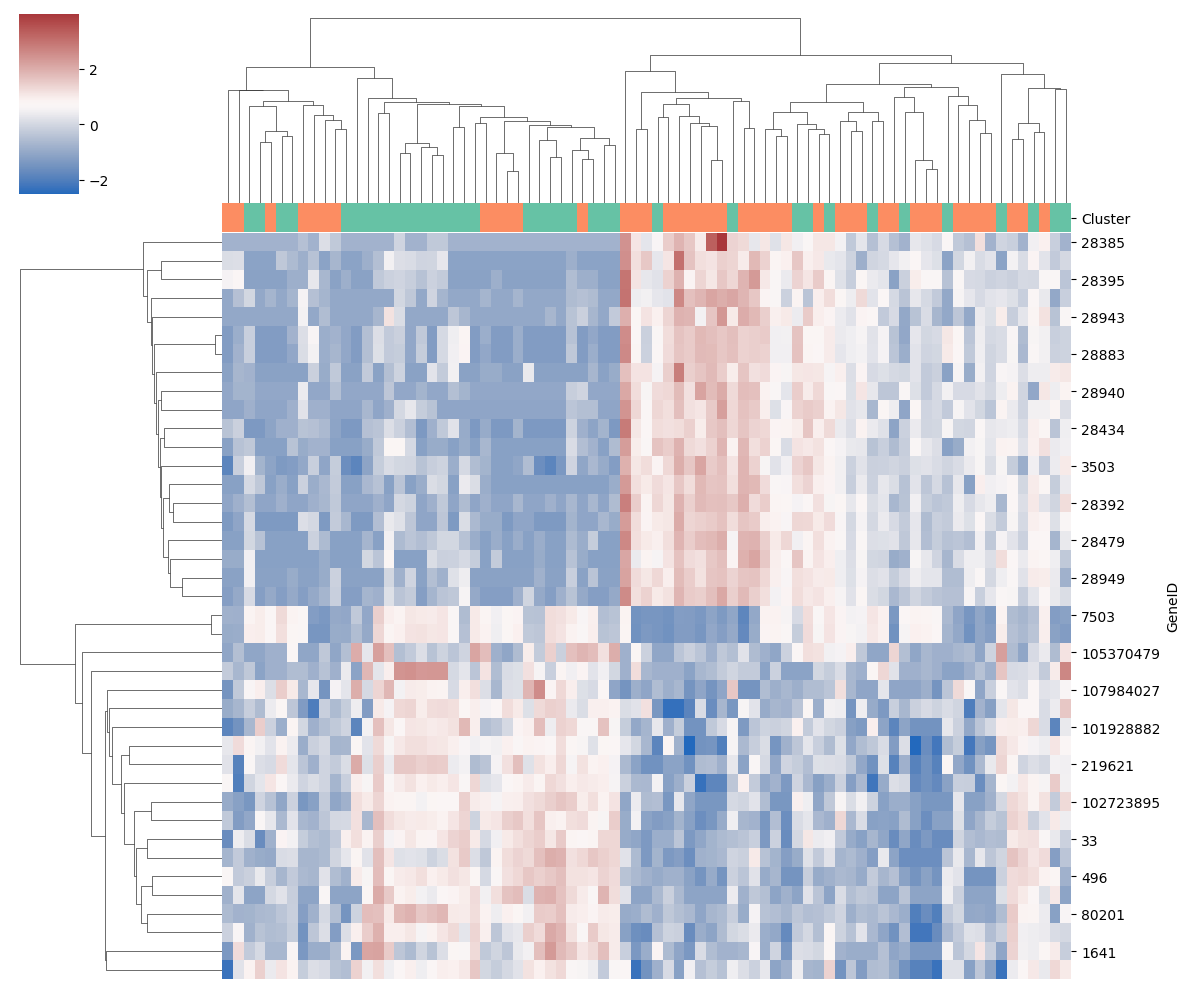

In [21]:
g = sns.clustermap(
    heatmap_data,
    col_colors=cluster_colors,
    z_score=0,
    cmap="vlag",
    xticklabels=False,
    figsize=(12, 10)
)

# Save to your results folder
g.savefig(
    r"C:\Users\Aina Rif'ah\Downloads\INTERNSHIP\PROJECT 2\results\cluster_marker_heatmap.png",
    dpi=300,
    bbox_inches="tight"
)


In [22]:
cluster0 = expr.loc[:, metadata["Cluster"] == 0]
others = expr.loc[:, metadata["Cluster"] != 0]

pvals = []
logfc = []

for gene in expr.index:
    t, p = ttest_ind(cluster0.loc[gene], others.loc[gene])
    pvals.append(p)
    logfc.append(
        cluster0.loc[gene].mean() - others.loc[gene].mean()
    )

de_results = pd.DataFrame({
    "gene": expr.index,
    "logFC": logfc,
    "pvalue": pvals
}).sort_values("pvalue")

de_results.head()


,gene,logFC,pvalue
17332,79684,1.998066,7.921464e-24
5159,132001,1.479289,1.257895e-23
16291,55761,1.557586,1.869082e-23
11871,64418,1.458533,2.709493e-23
4607,9330,1.445799,5.636409e-23


In [23]:
top_gene_list = marker_genes[0].index.tolist()


In [4]:
import pandas as pd

# Load log-normalized expression data
expr = pd.read_csv(
    "C:/Users/Aina Rif'ah/Downloads/INTERNSHIP/PROJECT 2/data/processed/GSE112509_log_normalized.csv",
    index_col=0
)

# Load metadata
metadata = pd.read_csv(
    "C:/Users/Aina Rif'ah/Downloads/INTERNSHIP/PROJECT 2/data/processed/GSE112509_metadata.csv",
    index_col=0
)

expr.shape, metadata.shape
import pandas as pd

# Reload cluster assignments from Week 4
cluster_df = pd.read_csv(
    "C:/Users/Aina Rif'ah/Downloads/INTERNSHIP/PROJECT 2/data/processed/sample_clusters_week4.csv",
    index_col=0
)

cluster_df.head()



,Cluster,Condition
GSM3071633,1,Benign
GSM3071634,1,Benign
GSM3071635,1,Benign
GSM3071636,1,Benign
GSM3071637,1,Benign


In [5]:
# Ensure sample order consistency
expr_clustered = expr.loc[:, cluster_df.index]

expr_clustered.shape


(29830, 79)

In [6]:
import pandas as pd

# Transpose so samples × genes, then add cluster labels
expr_samples = expr_clustered.T
expr_samples["Cluster"] = cluster_df["Cluster"]

# Mean expression per gene per cluster
cluster_means = expr_samples.groupby("Cluster").mean()

cluster_means.head()


GeneID,100287102,653635,102466751,107985730,645520,100996442,729737,102725121,102723897,102465909,...,4538,4564,4575,4568,4540,4541,4556,4519,4576,4571
Cluster,,,,,,,,,,,,,,,,,,,,,
0,3.263135,9.937157,4.989312,1.177501,0.866387,6.198984,8.329774,2.425937,10.183165,4.273646,...,18.745397,8.571084,8.681021,8.546085,17.573127,16.953474,13.524501,17.859896,9.919066,11.911118
1,3.322496,10.130548,5.042323,1.199191,0.824304,6.708189,7.551651,2.534347,10.412036,4.653497,...,19.694512,9.162768,9.422796,9.356406,18.419832,17.791310,14.214763,19.084537,10.222581,13.500790
2,4.462682,11.027791,6.242203,1.799886,1.657230,7.352568,8.737174,3.983035,11.217304,5.600382,...,20.957398,9.205720,9.753964,9.700521,19.529130,18.839216,15.044347,20.044080,11.611660,14.387222


In [7]:
top_genes_per_cluster = {}

for cluster in cluster_means.index:
    top_genes = (
        cluster_means.loc[cluster]
        .sort_values(ascending=False)
        .head(10)
    )
    top_genes_per_cluster[cluster] = top_genes

top_genes_per_cluster


{0: GeneID
 4512    19.109537
 4550    18.989877
 4538    18.745397
 4514    18.295803
 1915    18.204378
 4513    18.127219
 4508    18.070528
 4535    17.907391
 4519    17.859896
 4536    17.846159
 Name: 0, dtype: float64,
 1: GeneID
 4512    19.796926
 4538    19.694512
 4514    19.427039
 1915    19.410980
 4519    19.084537
 4550    18.959286
 4508    18.943361
 4535    18.926924
 4536    18.855203
 4513    18.810071
 Name: 1, dtype: float64,
 2: GeneID
 4512    21.190361
 4538    20.957398
 4514    20.647315
 4550    20.412316
 4513    20.325539
 4519    20.044080
 4508    20.027615
 4536    20.006963
 4535    19.873006
 4540    19.529130
 Name: 2, dtype: float64}

In [8]:
marker_genes = list(
    set(
        gene
        for genes in top_genes_per_cluster.values()
        for gene in genes.index
    )
)

len(marker_genes), marker_genes[:10]


(11, [4512, 4513, 4514, 4550, 4519, 4540, 4535, 4536, 4538, 1915])

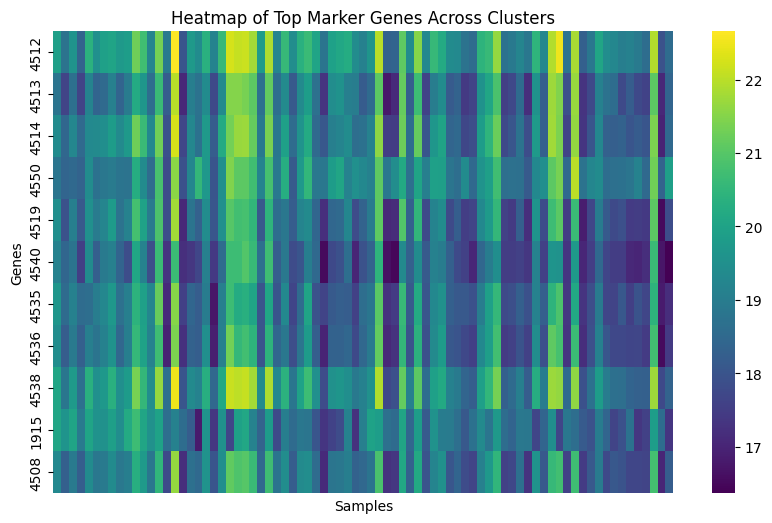

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(
    expr_clustered.loc[marker_genes],
    cmap="viridis",
    xticklabels=False,
    yticklabels=True
)
plt.title("Heatmap of Top Marker Genes Across Clusters")
plt.xlabel("Samples")
plt.ylabel("Genes")
plt.show()


In [16]:
ordered_samples = cluster_df.sort_values("Cluster").index
expr_ordered = expr_clustered[ordered_samples]


In [17]:
# Z-score per gene (row-wise) using pandas (safe for seaborn)
expr_z = expr_ordered.sub(expr_ordered.mean(axis=1), axis=0)
expr_z = expr_z.div(expr_ordered.std(axis=1), axis=0)



In [18]:
heatmap_data = expr_z.loc[marker_genes]



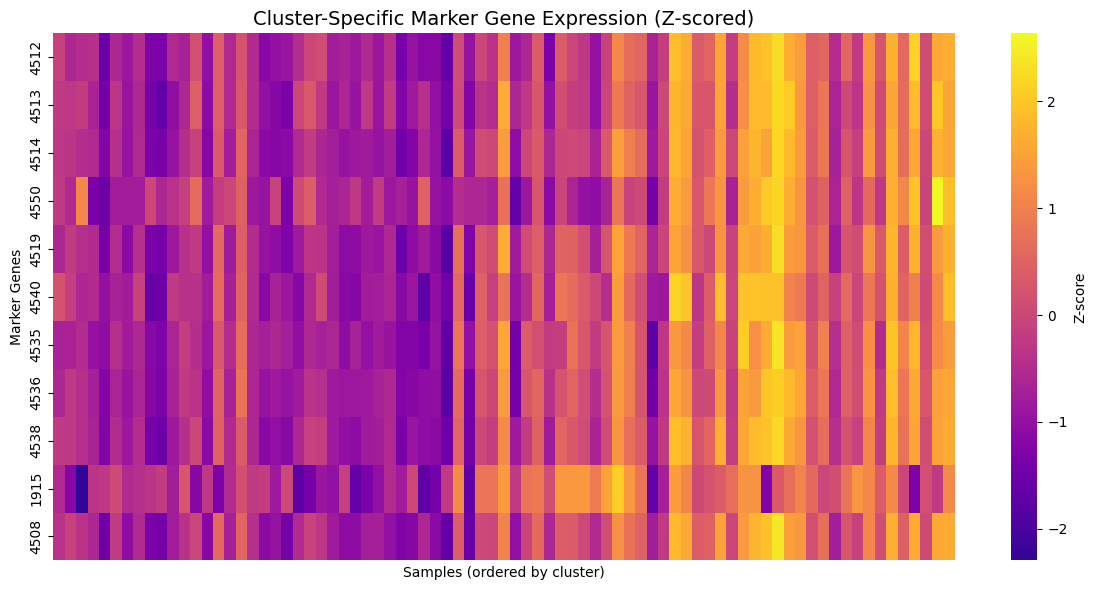

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

sns.heatmap(
    heatmap_data,
    cmap="plasma",
    center=0,
    xticklabels=False,
    yticklabels=True,
    cbar_kws={"label": "Z-score"},
    linewidths=0
)

plt.title("Cluster-Specific Marker Gene Expression (Z-scored)", fontsize=14)
plt.ylabel("Marker Genes")
plt.xlabel("Samples (ordered by cluster)")
plt.tight_layout()
plt.show()


In [22]:
# Save marker genes to CSV
marker_df = pd.concat(top_genes_per_cluster, axis=1)
marker_df.to_csv("C:/Users/Aina Rif'ah/Downloads/INTERNSHIP/PROJECT 2/data/processed/cluster_marker_genes_week5.csv")
